## <center> 1° Trabalho - Extração de informações de imóveis de sites de venda online <center>

### <center> Bibliotecas utilizadas <center>

A *urllib* foi utilizada para requisitar os protocolos do site.

A *BeautifulSoup* foi utilizada para pesquisa, tratamento e indentificação das informações.

A *Pandas* foi utilizada para tratamento e organização dos dados obtidos.

Um programa externo (plugin para o Mozilla Firefox), [ScrapeMate (Beta)](https://addons.mozilla.org/pt-BR/firefox/addon/scrapemate/) foi utilizado para facilitar a identificação dos elementos dentro da estrutura HTML.

In [1]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from unicodedata import normalize

### <center> Funções de leitura e extração de dados - OLX <center>

A função **"return_url"** abre a página principal da *OLX*, busca pelos anúncios de imóveis e retorna o hiperlink para cada anúncio.

In [2]:
def return_url(url_principal):
    req = Request(url_principal, headers={'User-Agent': 'Mozilla/5.0'})
    html = urlopen(req)
    page = BeautifulSoup(html)
    links = page.find_all("a", {"class":"fnmrjs-0"})
    return links

A função **"convert_valores"** permite pegar valores *strings* na notação com separação decimal por **vírgula (",")** e transforma-los em valores tipo *float* na notação com spearação decimal por **ponto (".")**.

In [3]:
def convert_valores(valor):
    valor_n = valor.replace(".", "")
    valor_f = valor_n.replace(",", ".")
    try:
        valor_f = float(valor_f)
    except:
        valor_f = 0.0
    
    return valor_f

A função **"return_data"** abre a página de um anúncio e extrai as informações exibidas na tela, retornando um dicionário com chaves pré-estabelecidas. A escolha dessas chaves se deu pela relevância das informações, por sua generalidade e pela possibilidade de utilização em modelos de *machine learning*. Os valores são:

Código: *string* código único do anúncio, criado pelo site. No contexto do trabalho, será usado para eliminar possíveis itens duplicados.

Categoria: *string* com informação do tipo de imóvel (em geral, casas ou apartamentos).

Condomínio: *float* com o valor do condomínio (se existir cobrança do valor).

Área: *int* contendo a área usável ou construída do imóvel.

Quartos: *string* contendo o número de quartos.

Banheiros: *string* contendo o número de banheiros.

Vagas na garagem: *string* contendo o número de vagas para carros.

Município: *string* informando o município onde está localizado o imóvel.

Bairro: *string* contendo o bairro do imóvel.

Preço: *float* com o preço do imóvel.


Para o número de quartos, banheiros e vagas de garagem, foi mantido a estrutura em *string*, dado a própria estrutura do site.

In [4]:
def return_data(url2):
    try:
        # requisição de conexão usando o Firefox
        req2 = Request(url2, headers={'User-Agent': 'Mozilla/5.0'})
        # recebimento da estrutura HTML da página
        html2 = urlopen(req2)
        # conversão para o objeto BS, trabalhado pela biblioteca.
        page2 = BeautifulSoup(html2)
        """
        list_infos: lista de chaves que devem ser coletadas. 
        Listar as informações permite padronizar o Dataset de uma maneira
        mais simples, dado que existem imóveis com informações adicionais (presença
        de piscinas e outros serviços em condomínios).
        
        Data_imovel: dicionário que contém o conjunto de informações dos imóveis.
        Cada item está descrito na explicação da função.
        
        """
        list_infos = ["Categoria", "Condomínio", "Área útil",\
                      "Área construída","Quartos", "Banheiros",\
                      "Vagas na garagem", "Município", "Bairro"]
    
        Data_imovel = {"Código":"", "Categoria": "", "Condomínio": 0, "Área": 0,\
                       "Quartos": "", "Banheiros": "", "Vagas na garagem": "",\
                      "Município": "", "Bairro": "", "Preço": 0}
        """
        As classes referentes dos objetos são da estrutura HTML.
        Sua identificação foi auxiliada pela inspeção de elemento do
        navegador Mozilla Firefox, assim como o plugin ScrapyMate, referenciado
        nas bibliotecas.
        
        infos_p: preço do imóvel.
        infos: chaves contendo o grupo de informações.
        infos_v: valores das informações relacionados as chaves.
        info_code: código do anúncio, único no site.
        
        """
        
        infos_p = page2.find_all("h2", {"class":"JzEH"})[0].text[3:]
        infos = page2.find_all("dt", {"class":"cLGFbW"})
        infos_v = page2.find_all("div", {"class":"duvuxf-0 h3us20-0 jyICCp"})
        info_cod = page2.find_all("span", {"class": "qJvUT"})
    
        Data_imovel["Preço"] = convert_valores(infos_p)
        Data_imovel["Código"] = info_cod[0].text[5: ]
        for i, j in zip(infos, infos_v):
            if i.text not in list_infos:
                pass
            elif i.text in ["Área útil", "Área construída"]:
                Data_imovel["Área"] = int(j.text[len(i.text):len(j.text) - 2])
            elif i.text == "Condomínio":
                Data_imovel[i.text] = convert_valores(j.text[len(i.text) + 3: ])
            else:
                Data_imovel[i.text] = j.text[len(i.text):]
        return Data_imovel
    except:
        return 0

In [5]:
def corrigir_numero(num):
    n = ""
    for i in num:
        if i != "." and i != " " and i != ",":
            n += i
    return int(n)
#int(corrigir_numero(quantidade[0].text)/50)
def corrigir_bairro(texto):
    t = ""
    for i in texto:
        if i != " ":
            t += i
        else:
            t += "-"
    return t.lower()

### <center> Exemplo de uso <center>

In [6]:
url = "https://ce.olx.com.br/fortaleza-e-regiao/imoveis/casa-para-venda-em-conjunto-ceara-i-fortaleza-ceara-976014304"
return_data(url)

{'Código': '976014304',
 'Categoria': 'Casas',
 'Condomínio': 0,
 'Área': 160,
 'Quartos': '3',
 'Banheiros': '3',
 'Vagas na garagem': '2',
 'Município': 'Fortaleza',
 'Bairro': 'Conjunto Ceará I',
 'Preço': 20000.0}

### <center> Extração dos dados - Site OLX <center>

Para o exemplo do Dataset, foram analisadas 100 páginas do site de vendas [OLX](https://ce.olx.com.br/fortaleza-e-regiao/fortaleza/imoveis), com cada página contendo aproximadamente 50 anúncios de imóveis. Para a análise, considerou-se imóveis apenas do município de Fortaleza disponíveis para compra.

In [7]:
total_dados = [] # lista que irá conter o conjunto total de dados

In [8]:
url = "https://ce.olx.com.br/fortaleza-e-regiao/fortaleza/imoveis/venda"

driver = webdriver.Firefox("C:\\Users\\mateus\\Downloads\\geckodriver")
driver.get(url)

al = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.XPATH, '//*[text() = "Escolher bairros / cidades"]'))
)
al.click()

elem = driver.find_element_by_xpath("//*")
source_code = elem.get_attribute("outerHTML")
soup = BeautifulSoup(source_code, "html.parser")

In [9]:
bairros = soup.find_all("span", {"class":"yXlon"})
quantidade = soup.find_all("span", {"class":"fWUyFm"})
bairros.pop(0)
for i in range(len(quantidade)):
    print('{:<3}|Bairro: {:<25}| N° de imóveis:{:<1}'.format(i, bairros[i].text, quantidade[i].text))

0  |Bairro: Aerolândia               | N° de imóveis:, 53
1  |Bairro: Aldeota                  | N° de imóveis:, 3.475
2  |Bairro: Alto Alegre              | N° de imóveis:, 75
3  |Bairro: Álvaro Weyne             | N° de imóveis:, 95
4  |Bairro: Ancuri                   | N° de imóveis:, 87
5  |Bairro: Antônio Bezerra          | N° de imóveis:, 93
6  |Bairro: Antônio Diogo            | N° de imóveis:, 343
7  |Bairro: Barra do Ceará           | N° de imóveis:, 130
8  |Bairro: Barroso                  | N° de imóveis:, 109
9  |Bairro: Bela Vista               | N° de imóveis:, 44
10 |Bairro: Benfica                  | N° de imóveis:, 369
11 |Bairro: Bom Jardim               | N° de imóveis:, 330
12 |Bairro: Bonsucesso               | N° de imóveis:, 52
13 |Bairro: Cais do Porto            | N° de imóveis:, 40
14 |Bairro: Cajazeiras               | N° de imóveis:, 261
15 |Bairro: Cambeba                  | N° de imóveis:, 650
16 |Bairro: Canindezinho             | N° de imóveis:, 65
17 |

Processo de abertura e extração das informações.

In [ ]:
# 69
for i in range(69, 84):
    print('Bairro: {:<25}| N° de imóveis:{:<1}'.format(bairros[i].text, quantidade[i].text))
    
    bairro = normalize('NFKD', bairros[i].text).encode('ASCII','ignore').decode('ASCII')
    bairro = corrigir_bairro(bairro)
    
    url_principal = "https://ce.olx.com.br/fortaleza-e-regiao/fortaleza/" + bairro + "/imoveis/venda?o="
    print(url_principal)
    n = int(corrigir_numero(quantidade[i].text)/50) + 2
    if n > 101:
        n == 101
        
    contador = 0
    
    for j in range(1, n):
        print("Página N° %d"%(j))
        # retorna a lista de links para os anúncios descritos na página "i"
        try:
            links = return_url(url_principal + str(j))
        
            """
            para cada link, obtem-se as informações da página e retorna-se ou um dicionário
            contendo as informações, ou um valor 0, que indica que a página não pode ser aberta.
            """
        
            for k in links:
                link = k["href"]
                dados = return_data(link)
                if dados == 0:
                    pass
                else:
                    contador += 1
                    total_dados.append(dados)
        except:
            pass
    print("Número de imóveis: %d."%(contador))
    print("Percentual obtido: %.2f %s."%(contador/corrigir_numero(quantidade[i].text)*100, "%"))
    df = pd.DataFrame(total_dados)
    df.to_csv(bairro + ".csv")
    total_dados = []

Bairro: Passaré                  | N° de imóveis:, 1.452
https://ce.olx.com.br/fortaleza-e-regiao/fortaleza/passare/imoveis/venda?o=
Página N° 1
Página N° 2
Página N° 3
Página N° 4
Página N° 5
Página N° 6
Página N° 7
Página N° 8
Página N° 9
Página N° 10
Página N° 11
Página N° 12
Página N° 13
Página N° 14
Página N° 15
Página N° 16
Página N° 17
Página N° 18
Página N° 19
Página N° 20
Página N° 21
Página N° 22
Página N° 23
Página N° 24
Página N° 25
Página N° 26
Página N° 27
Página N° 28
Página N° 29
Página N° 30
Número de imóveis: 1354.
Percentual obtido: 93.25 %.
Bairro: Paupina                  | N° de imóveis:, 491
https://ce.olx.com.br/fortaleza-e-regiao/fortaleza/paupina/imoveis/venda?o=
Página N° 1
Página N° 2
Página N° 3
Página N° 4
Página N° 5
Página N° 6
Página N° 7
Página N° 8
Página N° 9
Página N° 10
Número de imóveis: 490.
Percentual obtido: 99.80 %.
Bairro: Pici                     | N° de imóveis:, 94
https://ce.olx.com.br/fortaleza-e-regiao/fortaleza/pici/imoveis/venda?o=
Pá

### <center> Correção e limpeza do Dataset <center>

Após a obtenção dos dados, foi feito o processo de limpeza do Dataset

##### 1° passo: Criação do objeto *Dataframe* 

In [12]:
df = pd.DataFrame(total_dados)
df.head()

,Código,Categoria,Condomínio,Área,Quartos,Banheiros,Vagas na garagem,Município,Bairro,Preço
0,976545556,Casas,0.0,108,3,2,2,Fortaleza,Aerolândia,180000.0
1,975806360,Apartamentos,230.0,42,2,1,1,Fortaleza,Alto da Balança,160000.0
2,975789387,Apartamentos,220.0,45,2,2,1,Fortaleza,Alto da Balança,190000.0
3,975789328,Casas,0.0,223,5 ou mais,3,1,Fortaleza,Aerolândia,250000.0
4,975752550,Apartamentos,220.0,45,2,2,1,Fortaleza,Alto da Balança,190000.0


In [13]:
df.describe()

,Condomínio,Área,Preço
count,53.000000,53.000000,5.300000e+01
mean,95.754717,1602.547170,3.190594e+05
std,157.897350,10861.501597,8.128960e+05
min,0.000000,0.000000,0.000000e+00
25%,0.000000,46.000000,1.300000e+05
50%,0.000000,82.000000,1.800000e+05
75%,208.000000,153.000000,2.500000e+05
max,570.000000,79180.000000,6.000000e+06


##### 2° passo: Remoção de itens duplicados *Dataframe* 

Devido ao processo de atualização da página (configurada para listagem de itens por ordem de "relevância), ocorre-se a possível mudança de localização de itens, o que gera itens repetidos 167 dos 4996 anúncios.

In [14]:
#itens duplicados
df[df.duplicated(['Código'])]

,Código,Categoria,Condomínio,Área,Quartos,Banheiros,Vagas na garagem,Município,Bairro,Preço


In [16]:
df_corrigido = df.drop_duplicates()
df_corrigido

,Código,Categoria,Condomínio,Área,Quartos,Banheiros,Vagas na garagem,Município,Bairro,Preço
0,976545556,Casas,0.0,108,3,2,2,Fortaleza,Aerolândia,180000.0
1,975806360,Apartamentos,230.0,42,2,1,1,Fortaleza,Alto da Balança,160000.0
2,975789387,Apartamentos,220.0,45,2,2,1,Fortaleza,Alto da Balança,190000.0
3,975789328,Casas,0.0,223,5 ou mais,3,1,Fortaleza,Aerolândia,250000.0
4,975752550,Apartamentos,220.0,45,2,2,1,Fortaleza,Alto da Balança,190000.0
5,968677273,Apartamentos,208.0,46,2,2,1,Fortaleza,Alto da Balança,160000.0
6,926374909,Casas,0.0,125,2,2,2,Fortaleza,Aerolândia,0.0
7,926374818,Casas,0.0,125,2,2,2,Fortaleza,Aerolândia,0.0
8,946635088,Apartamentos,533.0,62,3,2,1,Fortaleza,Alto da Balança,185000.0
9,680686171,Casas,0.0,82,3,2,2,Fortaleza,Alto da Balança,105000.0


##### 3° passo: Salvar Dataframe

Para registrar em um arquivo, a biblioteca *Pandas* possui o método *to_csv*, que registra as linhas
em um arquivo com padrão de separação por vírgula (",").

In [39]:
df.to_csv("Dataset_imoveis_olx.csv")

Com isso, o arquivo registrará as informações relevantes, permitindo utilização futura.

### <center> Considerações adicionais <center>

### Entraves e melhorias planejadas

Durante o estudo, foram detectados pequenos entraves específicos ao problema em si, que necessitam de algumas pequenas correções ainda.

Um exemplo é a presença de vendedores "mal intencionados", que postam informações de maneira incorreta. Durante a análise no site da OLX, presenciou-se um(a) vendendor(a) com informações incorretas quanto ao preço, postando apenas a entrada ao invés do valor total, como estratégia de atração de clientes. Provavelmente por questões de segurança, não
foi possível colocar um filtro nesse usuário em específico, mesmo a informação aparecendo no site. Para esse trabalho, considerou-se a presença como infima para afetar a relação dos dados. No entanto, uma boa maneira para remoção é verificar *out liers* inferiores, principalmente em bairros mais nobres.

Outro erro está na mudança de organização do site, que constatemente atualiza com a remoção e adição de novos imóveis. Como solução, deveria-se obter o Dataset sempre que se for fazer uma análise, de preferencia com valores mais altos e de forma contínua de um mesmo dispositivo. Além disso, deve-se ter o trabalho de remoção de valores duplicados, conforme foi feito no teste atual (cerca de 3,3% dos indices do Dataframe eram duplicados, valor relativamente baixo).

Para outros sites, como ZAP Imóveis, as mesmas considerações são verdadeiras, alterando-se poucas coisas no código, dado que a estrutura é parecida. As informações contidas podem variar em como são nomeadas.

### Motivação para os próximos trabalhos

Visualização: Observar a distribuição de imóveis pela cidade, permite uma análise quantitativa e qualitativa oferecendo padrões de crescimento na cidade, facilitando políticas públicas.

**Perguntas chaves:**

* Onde se constrõe mais em Fortaleza? 
* Onde se compra mais apartamentos? e mais casas?
* Qual a distribuição de preços em Fortaleza? 
* Quais as demandas e ofertas em questão de vagas para veículos? e Quartos? 
* O número de banheiros oferecidos por bairros tem relação com o IDH e outros
  índices de saúde e saneamento básico?

*Machine Learning*: Modelar fenômenos conforme os dados obtidos, afim de conseguir que um algorítmo seja capaz de responder a esses dados e que gere previsões de acordo com a realidade.

**Perguntas chaves:**

* Onde se tem maior valor de construção em Fortaleza? 
* Onde se tem os imóveis com melhor custo benefício? 
* Como saber o preço de mercado com base nas informações do imóvel que construi?
* Como identificar preços fora de mercado, podem ser fraudes? 
* Como a plataforma poderia usar isso para identificar problemas em 
  preços e informações incompatíveis com o produto?

### <center> Resumo dos dados <center>

In [50]:
df_corrigido.value_counts("Bairro")

Bairro
Meireles                         643
Aldeota                          461
Cocó                             287
Engenheiro Luciano Cavalcante    206
Papicu                           159
                                ... 
Cristo Redentor                    1
Olavo Oliveira                     1
Parque São José                    1
Pan Americano                      1
Conjunto Palmeiras                 1
Length: 119, dtype: int64

##### Comparação entre dois bairros

<img src = "Mapa-Lagoa_Redonda.jpg"><img src = "Mapa-Aldeota.jpg">

Fonte: [Prefeitura de Fortaleza](https://mapas.fortaleza.ce.gov.br/fortaleza-em-bairros/)

In [3]:
df_corrigido = pd.read_csv("Dataset_imoveis_olx.csv")
df_aldeota = df_corrigido.loc[df_corrigido["Bairro"] == "Aldeota"]
df_lagoa_redonda = df_corrigido.loc[df_corrigido["Bairro"] == "Lagoa Redonda"]

print("Número de imóveis a venda - Aldeota: %d"%(len(df_aldeota)))
print("Número de imóveis a venda - Lagoa Redonda: %d"%(len(df_lagoa_redonda)))

Número de imóveis a venda - Aldeota: 481
Número de imóveis a venda - Lagoa Redonda: 75


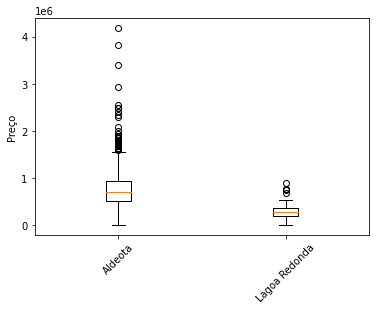

In [19]:
plt.boxplot([df_aldeota["Preço"], df_lagoa_redonda["Preço"]])
plt.ylabel("Preço")
plt.xticks([1, 2], ["Aldeota", "Lagoa Redonda"], rotation=45)
plt.show()

link para o [vídeo](https://youtu.be/EPziiPKZU3E)